# Libraries

In [2]:
from tqdm.notebook import tqdm
from typing import Optional, Tuple


import cupy as cp
import numba as nb
from numba import cuda,float32,int32

import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt
import math

import time

# Kernel Definitions

In [3]:
@cuda.jit
def acceleration_direct(x, mass, acc):
  '''
  Compute the acceleration for each particle in a given configuration x via brute force approach.

  '''
  i_col = cuda.grid(1) #Cuda 1d-grid initialization, i_col map to a singular thread the computation

  n0, n1 = x.shape
  # threads_per_grid_row, threads_per_grid_col = cuda.gridsize(2)

  if i_col <n1: #Check for out of boundery indexes

    for j in range(x.shape[0]):

      temp = 0

      for i in range(x.shape[0]):

        if i!=j:
          r=0
          for k in range(n1):
            r += (x[j, k] - x[i, k])*(x[j, k] - x[i, k])

          temp -= mass[j]*(x[j, i_col] - x[i, i_col])/math.sqrt(r)

      acc[j, i_col] = temp



In [4]:
@cuda.jit
def vv_pos(x0, v0, a0, dt, x1):
  '''
  Update the particle positions following the velocity-verlet schema.
  '''
  i_row, i_col = cuda.grid(2) #Cuda 2d-grid initialization, map to a singular thread the computation

  n0, n1 = x0.shape
  threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #Number of thread for each dimension in the grid

  for i0 in range(i_row, n0, threads_per_grid_x): #Stride loop in the 1st dimension, remap the problem for out of boundery threads
    for i1 in range(i_col, n1, threads_per_grid_y):#Stride loop in the 2nd dimension, remap the problem for out of boundery threads

      x1[i0, i1]  = x0[i0, i1]  + v0[i0, i1]*dt[0] + 0.5*a0[i0, i1]*dt[0]*dt[0] #Update positions


In [5]:
@cuda.jit
def vv_vel(v0, a0, a1, dt, v1):
  '''
  Update the particle velocities following the velocity-verlet schema.
  '''
  i_row, i_col = cuda.grid(2) #Cuda 2d-grid initialization, map to a singular thread the computation

  n0, n1 = v0.shape
  threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #Number of thread for each dimension in the grid

  for i0 in range(i_row, n0, threads_per_grid_x): #Stride loop in the 1st dimension, remap the problem for out of boundery threads
    for i1 in range(i_col, n1, threads_per_grid_y): #Stride loop in the 2nd dimension, remap the problem for out of boundery threads

      v1[i0, i1] = v0[i0, i1] + 0.5 * (a0[i0, i1] + a1[i0, i1])*dt[0] #Update velocities


In [6]:

@cuda.jit
def update(x1, v1, x0, v0):
  '''
  Copy into (x0,v0) the values of (x1, v1).
  '''
  i_row, i_col = cuda.grid(2) #Cuda 2d-grid initialization, map to a singular thread the computation

  n0, n1 = x1.shape
  threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #Number of thread for each dimension in the grid

  for i0 in range(i_row, n0, threads_per_grid_x): #Stride loop in the 1st dimension, remap the problem for out of boundery threads
    for i1 in range(i_col, n1, threads_per_grid_y): #Stride loop in the 2nd dimension, remap the problem for out of boundery threads
      x0[i0, i1] = x1[i0, i1] #Copy x1 into x0
      v0[i0, i1] = v1[i0, i1] #Copy v1 into v0

# Simulations Parameters

In [7]:
N_list = [100, 200, 500, 1_000]
N_dim  = 3 #(x,y,z)
N_streams = 5 #Number of simulation to be carried out in parallel
T = 1 #Number of simulation steps

## Streams Initialization

In [8]:
streams = [cuda.stream() for _ in range(0, N_streams)] #Stream initializations, each simulation will be mapped to a different stream

# Benchmarck

## Benchmark parameters and metrics

In [9]:
N_rep = 11 #10+1, the first one has to be descarded due to overhead times to load the kernarl

N_streams_ls = [1,2,3,4,5] #list of number of simulations
N_particles_ls = [100, 250, 500, 750, 1_000, 1_250, 1_500, 1_750, 2_000] #list of number of particles

time_matrix = np.zeros(shape=(len(N_streams_ls), len(N_particles_ls), N_rep-1))

In [10]:
threadsperblock = 256
blockspergrid = 64

## Loop

In [11]:
for idx_stream, N_streams in enumerate(N_streams_ls): #loop over number of simulation
  for idx_part, N_particles in enumerate(N_particles_ls): #loop over number of particles

    print(f'# Simulations:{N_streams}. # Particles: {N_particles}')

    #STREAMS DEFINITION
    streams = [cuda.stream() for _ in range(0, N_streams)] #Stream initializations, each simulation will be mapped to a different stream
    #_________________________________________________________________________________________________________

    #CONFIGURATION DEFINITION
    sim = np.zeros(shape=(N_streams, T, N_particles, N_dim)) #Array that will contain all the configuration generated by the simulations
                                                          #[Simulation, Simulation_step, Particle, coordinate]

    #Configurations must be initialized for each simulation into the same array
    #For example:
    #x0: [N_simulation, N_particles, Coordinates]
    #mass: [N_simulation, N_particles]

    x0 = np.random.normal(loc=0, scale=1, size = (N_streams,
                                                  N_particles,
                                                  N_dim))
    x1 = np.zeros((N_streams,
                  N_particles,
                  N_dim), dtype=np.float32)
    v0 = np.random.normal(loc=0, scale=1, size = (N_streams,
                                                  N_particles,
                                                  N_dim))
    v1 = np.zeros((N_streams,
                  N_particles,
                  N_dim), dtype=np.float32)
    mass = np.random.uniform(low=0, high=1, size = (N_streams,
                                                    N_particles))
    acc0 = np.zeros((N_streams,
                    N_particles,
                    N_dim), dtype=np.float32)
    acc1 = np.zeros((N_streams,
                    N_particles,
                    N_dim), dtype=np.float32)
    dt = np.array([0.01]) #To each simulation one could set a different time-step
    #___________________________________________________________________________________________________

    #COPY TO DEVICE
    #Each configuration is copied to the corrsponding device stream
    with cuda.pinned(x0, x1, v0, v1, acc0, acc1, mass, dt): #Pinning tells the host to keep this variables in memory

      for rep in range(N_rep): #loop over simulation repetition
        print(f'Iteretion {rep}', end='\t')

        for k, stream in enumerate(streams): #loop over streams

          d_x0 = cuda.to_device(x0, stream=stream)
          d_x1 = cuda.to_device(x1, stream=stream)

          d_v0 = cuda.to_device(v0, stream=stream)
          d_v1 = cuda.to_device(v1, stream=stream)

          d_mass = cuda.to_device(mass, stream=stream)

          d_acc0 = cuda.to_device(acc0, stream=stream)
          d_acc1 = cuda.to_device(acc1, stream=stream)

          d_dt = cuda.to_device(dt, stream=stream)
    #___________________________________________________________________________________________________

        #SIMULATIONS LOOP
        with cuda.pinned(sim):
          start = time.time() #Start timining first

          for t in range(T): #Simulations loop
            for k, stream in enumerate(streams):

              acceleration_direct[blockspergrid, threadsperblock, stream](d_x0[k], d_mass[k], d_acc0[k])
              vv_pos[(blockspergrid, blockspergrid), threadsperblock, stream](d_x0[k], d_v0[k], d_acc0[k], d_dt, d_x1[k])
              acceleration_direct[blockspergrid, threadsperblock, stream](d_x1[k], d_mass[k], d_acc1[k])
              vv_vel[(blockspergrid, blockspergrid), threadsperblock, stream](d_v0[k], d_acc0[k], d_acc1[k], d_dt, d_v1[k])
              update[(blockspergrid, blockspergrid), threadsperblock, stream](d_x1[k], d_v1[k], d_x0[k], d_v0[k])


              d_x0[k].copy_to_host(sim[k,t], stream=stream) #Copy d_x0 into sim for each simulation and simulation step

        end = time.time()
        print(end-start)
        if rep == N_rep-1:
          print('')
        if rep!=0:
          time_matrix[idx_stream, idx_part, rep-1] = end-start

# Simulations:1. # Particles: 100
Iteretion 0	

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1.807194471359253
Iteretion 1	0.05078721046447754
Iteretion 2	0.05057072639465332
Iteretion 3	0.050612449645996094
Iteretion 4	0.050549983978271484
Iteretion 5	0.0462191104888916
Iteretion 6	0.021960973739624023
Iteretion 7	0.021913766860961914
Iteretion 8	0.02193307876586914
Iteretion 9	0.02210712432861328
Iteretion 10	0.02169489860534668

# Simulations:1. # Particles: 250
Iteretion 0	

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0.12569141387939453
Iteretion 1	0.11646604537963867
Iteretion 2	0.11609458923339844
Iteretion 3	0.11623120307922363
Iteretion 4	0.11849379539489746
Iteretion 5	0.11611199378967285
Iteretion 6	0.11613345146179199
Iteretion 7	0.1160886287689209
Iteretion 8	0.1161038875579834
Iteretion 9	0.11634993553161621
Iteretion 10	0.11622262001037598

# Simulations:1. # Particles: 500
Iteretion 0	0.4633338451385498
Iteretion 1	0.46336817741394043
Iteretion 2	0.46595263481140137
Iteretion 3	0.4633207321166992
Iteretion 4	0.4661095142364502
Iteretion 5	0.46350932121276855
Iteretion 6	0.463428258895874
Iteretion 7	0.46361351013183594
Iteretion 8	0.464047908782959
Iteretion 9	0.4635884761810303
Iteretion 10	0.463547945022583

# Simulations:1. # Particles: 750
Iteretion 0	1.0425300598144531
Iteretion 1	1.043363094329834
Iteretion 2	1.0422334671020508
Iteretion 3	1.0421714782714844
Iteretion 4	1.0421726703643799
Iteretion 5	1.0421879291534424
Iteretion 6	1.0447883605957031
Iteretion 7	1.042102575302124
It

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
np.save('/content/drive/MyDrive/Giacomo/time_matrix', time_matrix)

In [20]:
mean_time = time_matrix.mean(axis=2)
std_time = time_matrix.std(axis=2)

In [64]:
from matplotlib.pyplot import cm

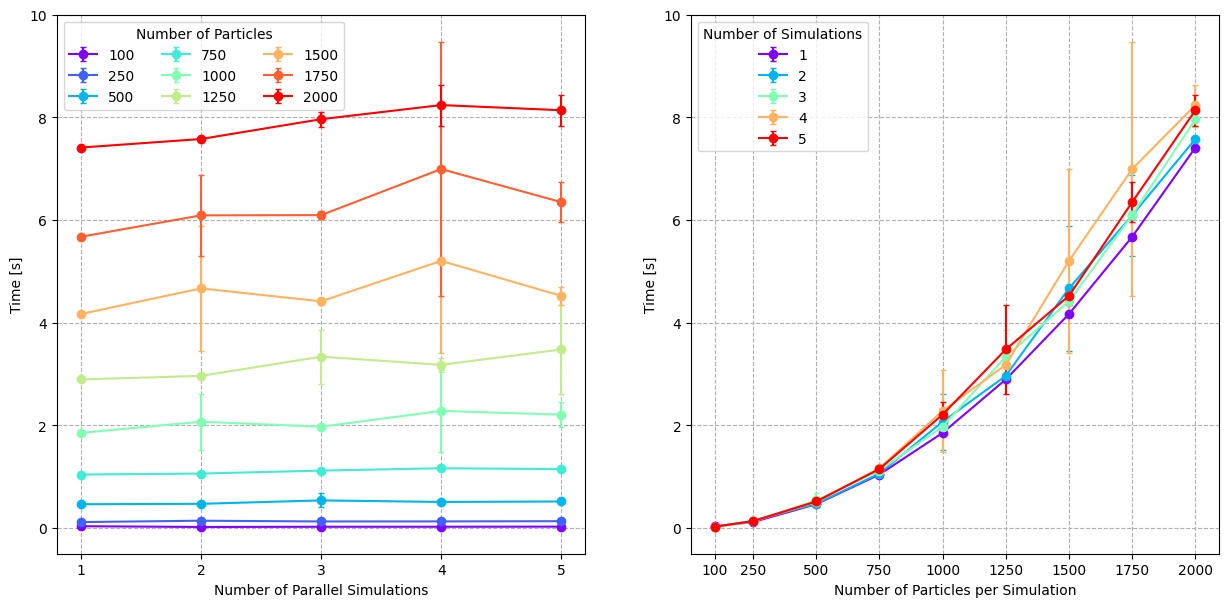

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

color_part = cm.rainbow(np.linspace(0, 1, mean_time.shape[1]))
color_sim = cm.rainbow(np.linspace(0, 1, mean_time.shape[0]))

for n_part in range(mean_time.shape[1]):

  ax[0].errorbar(x=N_streams_ls,
                 y=mean_time.T[n_part],
                 yerr = std_time.T[n_part],
                 capsize = 2,
                 fmt='-o',
                 color = color_part[n_part],
                 label=f'{N_particles_ls[n_part]}')

ax[0].legend(loc='upper left', ncols=3, fontsize=10, title='Number of Particles')
ax[0].grid(linestyle='--')

ax[0].set_xticks(N_streams_ls)

ax[0].set_ylim(-0.5,10)
ax[0].set_xlabel('Number of Parallel Simulations')
ax[0].set_ylabel('Time [s]')


for n_stream in range(mean_time.shape[0]):

  ax[1].errorbar(x=N_particles_ls,
                 y=mean_time[n_stream],
                 yerr = std_time[n_stream],
                 capsize = 2,
                 fmt='-o', color = color_sim[n_stream],
                 label=f'{N_streams_ls[n_stream]}')

ax[1].legend(loc='upper left', title='Number of Simulations')
ax[1].grid(linestyle='--')

ax[1].set_xticks(N_particles_ls)

ax[1].set_ylim(-0.5,10)
ax[1].set_xlabel('Number of Particles per Simulation')
ax[1].set_ylabel('Time [s]')

fig.savefig('/content/drive/MyDrive/Giacomo/NumbaCuda_Benchamark.png', dpi=300)